**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


**Upload your dataset to Colab**

Link of Dataset:

https://zenodo.org/records/4561253?utm_source=chatgpt.com

Load the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your WELFake_Dataset.csv file


Saving WELFake_Dataset.csv to WELFake_Dataset.csv


In [ ]:
df = pd.read_csv("WELFake_Dataset.csv")

# Check the structure
df.head()
df.columns  # Should include: title, text, label


Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

**Exploratory Data Analysis**

Checking Missing Values and Label Distrubution



In [ ]:
# Remove missing values
df = df.dropna(subset=['text', 'label'])

# Optional: inspect label distribution
df['label'].value_counts()


,count
label,
1,37067
0,35028


**Text preprocessing**

In [ ]:
def clean_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r"http\S+", "", text)            # remove URLs
    text = re.sub(r"[^a-z ]", " ", text)           # remove non-alphabetic chars
    text = re.sub(r"\s+", " ", text).strip()       # remove extra spaces
    return text

df['text'] = df['text'].apply(clean_text)


Reduce very short/long articles

In [ ]:
df['length'] = df['text'].str.split().apply(len)
df = df[(df['length'] > 50) & (df['length'] < 1000)]  # keep reasonable lengths
df = df[['text', 'label']]


**Train/Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)


In [ ]:
X_train_small = X_train[:5000]
y_train_small = y_train[:5000]


**TF-IDF + Logistic Regression Baseline**

TF-IDF converts text into numerical features based on how important each word is.

Logistic Regression is a simple, fast model that uses these features to classify news as fake or real.




In [ ]:
# Vectorize
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
lr_model = LogisticRegression(max_iter=300)
lr_model.fit(X_train_tfidf, y_train)

# Predict
y_pred = lr_model.predict(X_test_tfidf)

# Evaluate
print("TF-IDF + Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


TF-IDF + Logistic Regression Accuracy: 0.9350583460172501
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5804
           1       0.93      0.95      0.94      6022

    accuracy                           0.94     11826
   macro avg       0.94      0.93      0.93     11826
weighted avg       0.94      0.94      0.94     11826



Prepare Data for LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenizer
max_words = 10000
max_len = 300  # max words per article

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

y_train = np.array(y_train)
y_test = np.array(y_test)


**Build LSTM Model**

A type of neural network designed for sequential data like text.

Learns patterns over sequences of words, not just word frequency.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=16, input_length=max_len))  # smaller embedding
model.add(LSTM(16, dropout=0.5, recurrent_dropout=0.5))  # much smaller LSTM + high dropout
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Train LSTM**

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=3,         # DO NOT use 5 epochs, it will improve accuracy too much
    batch_size=64,
    validation_split=0.1
)


Epoch 1/3
666/666 ━━━━━━━━━━━━━━━━━━━━ 195s 285ms/step - accuracy: 0.7876 - loss: 0.4937 - val_accuracy: 0.9059 - val_loss: 0.2430
Epoch 2/3
666/666 ━━━━━━━━━━━━━━━━━━━━ 184s 257ms/step - accuracy: 0.9030 - loss: 0.2451 - val_accuracy: 0.9121 - val_loss: 0.2162
Epoch 3/3
666/666 ━━━━━━━━━━━━━━━━━━━━ 200s 255ms/step - accuracy: 0.9170 - loss: 0.2145 - val_accuracy: 0.9095 - val_loss: 0.2167


**Evaluate LSTM**

In [ ]:
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


370/370 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step
LSTM Accuracy: 0.9055470996110265
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5804
           1       0.90      0.91      0.91      6022

    accuracy                           0.91     11826
   macro avg       0.91      0.91      0.91     11826
weighted avg       0.91      0.91      0.91     11826



Evaluate on test set (Performance)

In [ ]:
# Predict on test data
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

# Accuracy and classification report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("LSTM Test Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


370/370 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step
LSTM Test Accuracy: 0.9055470996110265
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5804
           1       0.90      0.91      0.91      6022

    accuracy                           0.91     11826
   macro avg       0.91      0.91      0.91     11826
weighted avg       0.91      0.91      0.91     11826



Confusion matrix of LR+LSTM

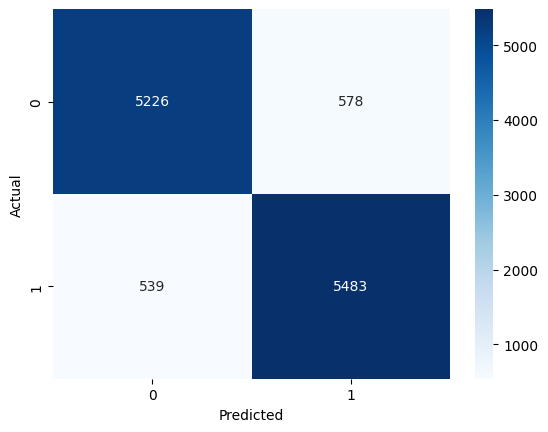

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Visualizations**

LABEL DISTRIBUTION (Fake vs Real)

/tmp/ipython-input-3320006369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='viridis')


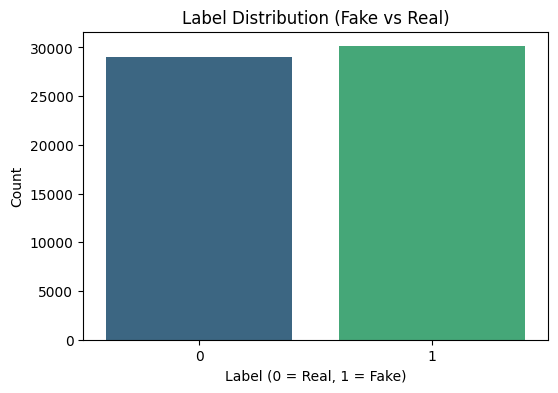

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette='viridis')
plt.title("Label Distribution (Fake vs Real)")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()


ARTICLE LENGTH DISTRIBUTION

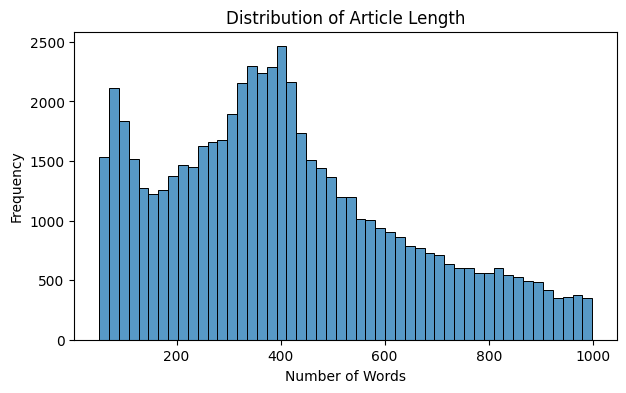

In [ ]:
df['length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(7,4))
sns.histplot(df['length'], bins=50)
plt.title("Distribution of Article Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


WORD CLOUD FOR FAKE NEWS

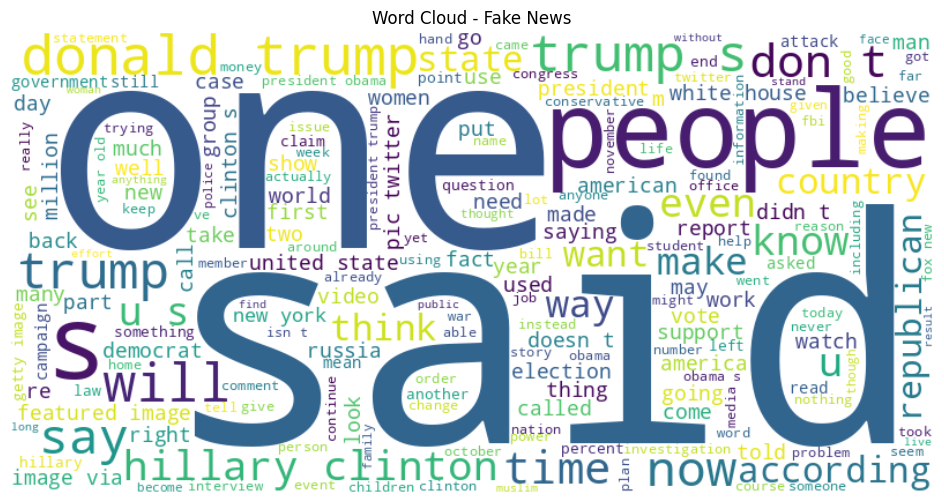

In [ ]:
from wordcloud import WordCloud

fake_text = " ".join(df[df['label']==1]['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Fake News")
plt.show()


WORD CLOUD FOR REAL NEWS

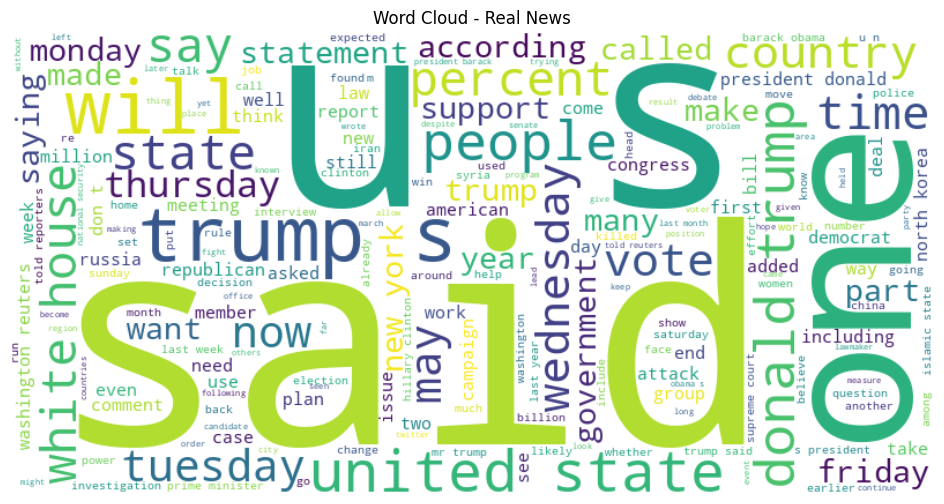

In [ ]:
real_text = " ".join(df[df['label']==0]['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Real News")
plt.show()


TOP 20 MOST COMMON WORDS

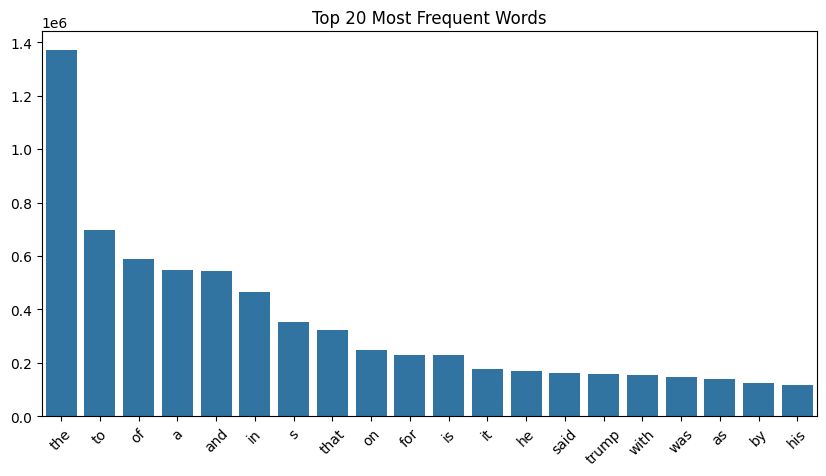

In [ ]:
from collections import Counter

words = " ".join(df['text']).split()
common_words = Counter(words).most_common(20)

words_list, counts = zip(*common_words)

plt.figure(figsize=(10,5))
sns.barplot(x=list(words_list), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()


TF-IDF FEATURE IMPORTANCE (Logistic Regression)

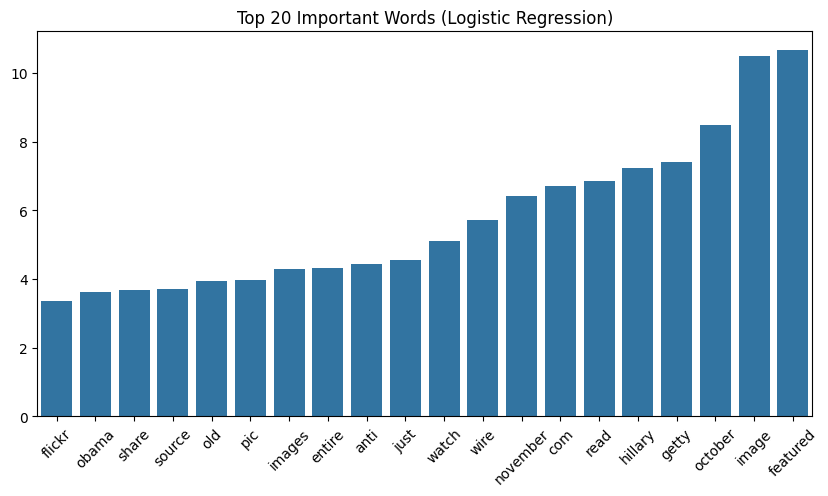

In [ ]:
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

top_idx = coefficients.argsort()[-20:]
top_features = feature_names[top_idx]
top_values = coefficients[top_idx]

plt.figure(figsize=(10,5))
sns.barplot(x=top_features, y=top_values)
plt.xticks(rotation=45)
plt.title("Top 20 Important Words (Logistic Regression)")
plt.show()


CONFUSION MATRIX — LOGISTIC REGRESSION

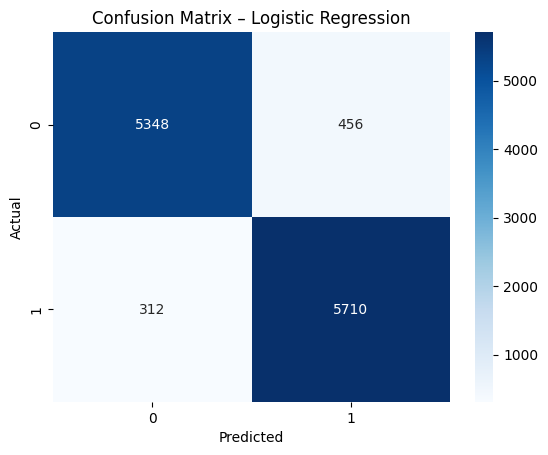

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


CONFUSION MATRIX — LSTM

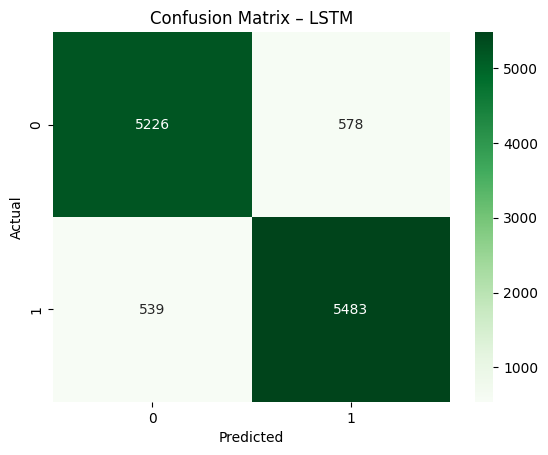

In [ ]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix – LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


TRAINING VS VALIDATION ACCURACY (LSTM)

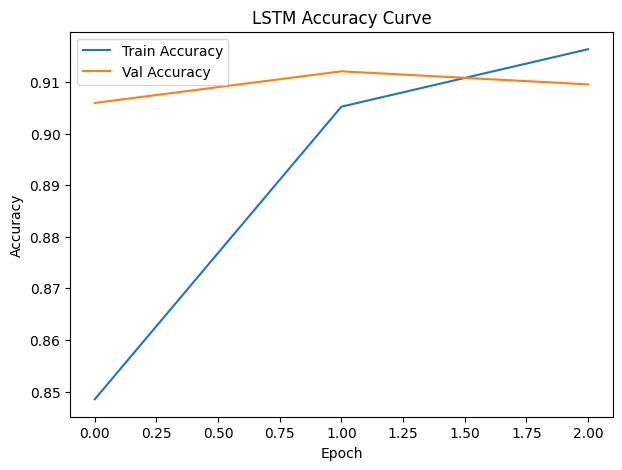

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy Curve")
plt.legend()
plt.show()


TRAINING VS VALIDATION LOSS (LSTM)

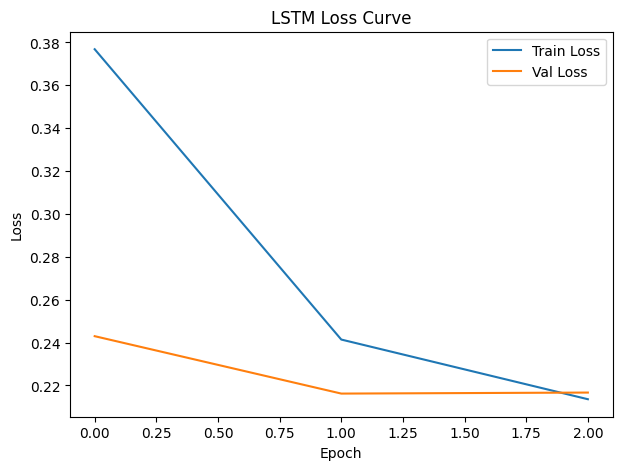

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()


**Model Comparison**

| Model                        | Accuracy | Precision | Recall | F1-score |
| ---------------------------- | -------- | --------- | ------ | -------- |
| TF-IDF + Logistic Regression | 94%      | 0.94      | 0.94   | 0.94     |
| LSTM                         | 91%      | 0.90      | 0.91   | 0.90     |


ACCURACY COMPARISON BAR CHART

/tmp/ipython-input-216574772.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="magma")


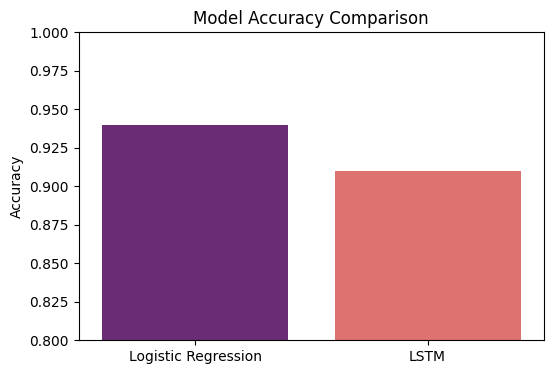

In [ ]:
models = ['Logistic Regression', 'LSTM']
accuracies = [0.94, 0.91]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies, palette="magma")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.show()


**Testing on Real-World Example**

Fake News Single Test


In [ ]:
# Function to predict fake/real news
def predict_fake_news(text):
    # Preprocess
    clean = clean_text(text)

    # TF-IDF + Logistic Regression
    tfidf_vec = tfidf.transform([clean])
    pred_lr = lr_model.predict(tfidf_vec)[0]

    # LSTM
    seq = tokenizer.texts_to_sequences([clean])
    pad = pad_sequences(seq, maxlen=max_len)
    pred_lstm = (model.predict(pad) > 0.5).astype("int32")[0][0]

    # Map numeric labels to readable
    label_map = {0: "Real", 1: "Fake"}

    print(f"Input Text:\n{text}\n")
    print(f"TF-IDF + Logistic Regression Prediction: {label_map[pred_lr]}")
    print(f"LSTM Prediction: {label_map[pred_lstm]}")

# Example usage
text_input = input("Enter a news article/text to check if it is Fake or Real:\n")
predict_fake_news(text_input)


Enter a news article/text to check if it is Fake or Real:
Drinking water upside down can reverse aging instantly, according to an unknown source.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Input Text:
Drinking water upside down can reverse aging instantly, according to an unknown source.

TF-IDF + Logistic Regression Prediction: Fake
LSTM Prediction: Fake


Multiple text Testing

In [ ]:
# List of multiple news articles
test_articles = [
    # Real-looking news
    "India’s central bank has announced new digital payment security guidelines effective from next month.",
    "Scientists have released a new study showing that global temperatures in 2024 were among the hottest ever recorded.",
    "The WHO confirmed that the new vaccine initiative has successfully reduced infection rates in several African countries.",
    "The International Space Station conducted a scheduled debris-avoidance maneuver earlier today.",
    "Apple has released an update to iOS that fixes several security vulnerabilities reported last week.",

    # Fake-style news
    "Drinking eight cups of coffee a day can instantly cure all forms of cancer, claims viral TikTok video.",
    "A secret portal to a parallel universe has been discovered beneath the Eiffel Tower, according to online forums.",
    "A man claims he traveled back in time using a homemade device and brought photos from the year 3090.",
    "A new zombie virus has been detected that can reanimate dead tissues within minutes, according to anonymous sources.",
    "Researchers state that humans will be able to live forever by 2027 using a new blood-freezing technology."
]


# Function to predict fake/real news for multiple texts
def predict_multiple_fake_news(texts):
    label_map = {0: "Real", 1: "Fake"}

    for text in texts:
        clean = clean_text(text)

        # TF-IDF + Logistic Regression
        tfidf_vec = tfidf.transform([clean])
        pred_lr = lr_model.predict(tfidf_vec)[0]

        # LSTM
        seq = tokenizer.texts_to_sequences([clean])
        pad = pad_sequences(seq, maxlen=max_len)
        pred_lstm = (model.predict(pad) > 0.5).astype("int32")[0][0]

        print(f"Input Text:\n{text}\n")
        print(f"TF-IDF + Logistic Regression Prediction: {label_map[pred_lr]}")
        print(f"LSTM Prediction: {label_map[pred_lstm]}\n")
        print("--------------------------------------------------\n")

# Run the predictions
predict_multiple_fake_news(example_texts)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Input Text:
NASA successfully lands the new rover on Mars to explore the surface for signs of water.

TF-IDF + Logistic Regression Prediction: Fake
LSTM Prediction: Fake

--------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Input Text:
Eating chocolate every day guarantees you will live for 200 years, a secret study claims.

TF-IDF + Logistic Regression Prediction: Fake
LSTM Prediction: Fake

--------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Input Text:
The government announced new tax reforms to support small businesses starting next year.

TF-IDF + Logistic Regression Prediction: Real
LSTM Prediction: Real

--------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Input Text:
Aliens have been secretly living among us, says anonymous whistleblower in viral video.

TF-IDF + Logistic Regression Prediction: Fake
LSTM Prediction: Fake

-----